# A Digital Twin Approach to World Cup Modelling

Prever resultados de jogos é um passatempo, e ganha pão, de muitos nerds, sendo a Copa do Mundo o maior troféu. Você consegue achar predições usando uma [grande](http://previsaoesportiva.com.br/campeonatos/copa2018/boxplot.html) [variedade](http://www.chancedegol.com.br/copa18.htm) de [modelos](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook) por aí, mas aqui vamos pensar em algo um pouco diferente. E se tivéssemos um Digital Twin de cada seleção?

[Um gêmeo digital é uma cópia digital de uma coisa física](https://en.wikipedia.org/wiki/Digital_twin). Como a cópia é digital, você pode usar ela para prever muitas coisas impraticáveis no mundo físico, como simular urubus entrando no digital twin de uma turbina de avião ou anteceder falhas em turbinas eólicas em locais inacessíveis.

É claro que definir esse bixo é muito mais fácil do que construir ele. Muita gente também vai se perguntar se isso não é a mesma coisa que as simulações da engenharia, ou machine learning e otimização. A resposta é: sim e não.

![Isso tem que ser falado](infelizmente.jpg)

Você forma um digital twin com um pouco de tudo isso aí. Um sistema de muitas partículas interagindo, como uma proteína, pode ser simulada através da descrição física de como cada um de seus vários atómos reage de acordo com variáveis do ambiente e interação com outros átomos. Em sistemas mais complicados, como pessoas conversando ou processos mais complexos, não temos o luxo de, partindo das leis da física, prever como uma pessoa vai agir. E daí entra o Machine Learning: aprendemos com o histórico como representar uma certa entidade e, depois, estamos livres para simular ela interagindo com o mundo e outras entidades.

No problema da Copa do Mundo temos duas possibilidades: podemos separar os dados de cada seleção e construir um modelo para cada, ou podemos fazer um grande preditor de resultado de jogos, olhando para todos os resultados de todos os jogos e, na hora do uso, alimentarmos essa máquina com somente os jogos de uma seleção para prever os seus resultados. A primeira abordagem é um pouco mais óbvia: jogos e dados do Brasil são usados para prever resultados do Brasil. Entretanto a segunda abordagem, mesmo que mais confusa, é mais rica: ela permite aproveitarmos todos os dados disponíveis e fazer previsões para o Brasil utilizando situações parecidas que ocorreram com outras seleções.

Em todo caso, é melhor avançarmos aos poucos. Na Seção 1 descrevo os dados que considerei na modelagem. Na Seção 2 faço um Digital Twin exclusivo com dados do Brasil e, na Seção 3, generalizo para construção de um Digital Twin de seleções.

# 1. Dados que eu peguei de outra pessoa

O usuário do Kaggle Agostonkorok já nos fez o grande favor de coletar os [principais dados](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook) utilizados na previsão de jogos de seleções. Temos três conjuntos.

O primeiro é o ranking da Fifa, que contém a posição de cada país com uma precisão absurda (mensal):

In [1]:
import pandas as pd

ranking_fifa = pd.read_csv("Data/fifa_ranking.csv")
print(ranking_fifa.shape)
ranking_fifa

(57793, 16)


,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.00,57,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
1,2,Italy,ITA,0.00,57,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
2,3,Switzerland,SUI,0.00,50,9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
3,4,Sweden,SWE,0.00,55,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
4,5,Argentina,ARG,0.00,51,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONMEBOL,1993-08-08
5,6,Republic of Ireland,IRL,0.00,54,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
6,7,Russia,RUS,0.00,52,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
7,8,Brazil,BRA,0.00,55,-5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONMEBOL,1993-08-08
8,9,Norway,NOR,0.00,49,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
9,10,Denmark,DEN,0.00,51,-1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08


Tab. 1. Ranking da Fifa. Tem informação aí desde 1993, melhor que muito dado público que se vê por aí. 

O segundo é uma mistura de dados históricos sobre as seleções da copa atual e informações sobre os jogos da primeira fase:

In [2]:
world_cup = pd.read_csv("Data/World Cup 2018 Dataset.csv")
print(world_cup.shape)
world_cup.head(5)

(33, 20)


,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


Tab. 2: Resumo sobre as seleções da copa. Mas que excelente ideia colocar informações passadas e futuras na mesma tabela.

Por último, e mais importante, um resumo do resultado de todos os jogos entre seleções da história

In [3]:
game_result = pd.read_csv("Data/results.csv")
print(game_result.shape)
game_result.head(5)

(39045, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Tab. 3. Todos os jogos da história. Nessa tabela o Palmeiras também não tem mundial.

Nossos dados contém dois tipos de informação. As tabelas ranking_fifa e world_cup contém dados sobre o perfil da seleção, enquanto a tabela game_result contém uma espécie de linha do tempo de uma seleção. Essa distinção será muito importante para um Digital Twin, já que o queremos prever é uma continuação dessa linha do tempo.

# 2. Digital Twin do Brasil

Vamos filtrar os dados para considerar somente os jogos do Brasil no histórico. Vou desconsiderar informações de mandante de campo porque é difícil considerar isso em uma copa do mundo.

In [4]:
game_result_brasil_home = game_result[game_result['home_team'] == 'Brazil']
print(game_result_brasil_home.shape)

game_result_brasil_away = game_result[game_result['away_team'] == 'Brazil']
print(game_result_brasil_away.shape)

def vconcat_home_away_results(away_df,home_df):    
    
    results = pd.concat([away_df.rename(columns={'home_team' : 'team2','away_team':'team1',
                    'home_score': 'team2_score','away_score':'team1_score'}),\
                         home_df.rename(columns={'home_team' : 'team1','away_team':'team2',
                    'home_score': 'team1_score','away_score':'team2_score'})])
    
    results['AAAA-MM'] = results['date'].str[:7]
    
    return results.drop(['tournament','city','country','neutral'],axis=1)

game_results_brasil = vconcat_home_away_results(game_result_brasil_away,game_result_brasil_home)
print(game_results_brasil.shape)
game_results_brasil.head(5)

(548, 9)
(403, 9)
(951, 6)


,date,team1,team1_score,team2,team2_score,AAAA-MM
398,1914-09-20,Brazil,0,Argentina,3,1914-09
399,1914-09-27,Brazil,1,Argentina,0,1914-09
424,1916-07-10,Brazil,1,Argentina,1,1916-07
429,1916-07-18,Brazil,1,Uruguay,0,1916-07
454,1917-10-03,Brazil,2,Argentina,4,1917-10


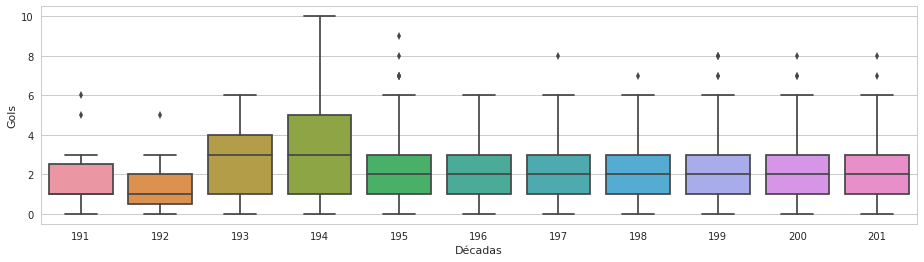

In [5]:
%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize':(15.7,4)})
sns.set_style("whitegrid")

ax = sns.boxplot(y=game_results_brasil['team1_score'], 
                 x=game_results_brasil['AAAA-MM'].str[:3])
ax.set_xlabel('Décadas')
ax.set_ylabel('Gols')

Tab. 4. Gols do Brasil ao longo das décadas. As coisas foram animadas mesmo nos anos 40.

Preciso de informações do ranking do Brasil (team1) e do adversário (team2) no momento do jogo. Essas são as informações de "perfil" dos nossos times, enquanto os jogos representam a linha do tempo da seleção.

Filtrar com a tabela de rankings da Fifa também ajuda a manter somente informações de jogos mais recentes.

In [6]:
ranking_fifa['AAAA-MM'] = ranking_fifa['rank_date'].str[:7]

game_results_rkteam1 = pd.merge(game_results_brasil, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['team1','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                       )

game_results_rk_brasil = pd.merge(game_results_rkteam1, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['team2','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                        suffixes=('','_team2')
                       )

game_results_rk_brasil.shape

(342, 36)

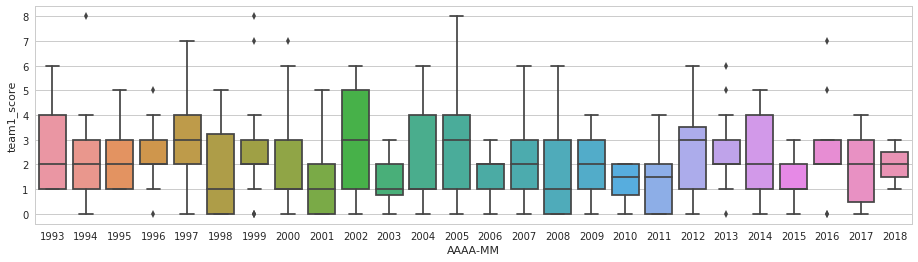

In [7]:
ax = sns.boxplot(y=game_results_rk_brasil['team1_score'], 
                 x=game_results_rk_brasil['AAAA-MM'].str[:4])

Com a tabela game_results_rk_brasil podemos começar a modelar. Aqui team1 representa o Brasil e team2 o adversário. Como temos poucos jogos, vamos tentar prever somente se houve vitória, derrota ou empate do Brasil.

In [16]:
def construct_target(df,team1_score_feature,team2_score_feature):    
    return df.apply(lambda row : 'WIN' if row[team1_score_feature] > row[team2_score_feature]
                                       else 'LOS' if row[team2_score_feature] > row[team1_score_feature]
                                       else 'DRW',axis=1)

game_results_rk_brasil['TARGET'] = construct_target(game_results_rk_brasil,'team1_score','team2_score')
game_results_rk_brasil[['team1_score','team2_score','TARGET']].head(5)

,team1_score,team2_score,TARGET
0,5,1,WIN
1,1,1,DRW
2,1,1,DRW
3,2,0,WIN
4,6,0,WIN


In [9]:
game_results_rk_brasil.groupby(by='TARGET').count()['date']

TARGET
DRW     70
LOS     48
WIN    224
Name: date, dtype: int64

Essas são as colunas úteis para modelarmos:

In [10]:
variables = ['rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 'cur_year_avg_weighted', 'last_year_avg',
'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg', 'three_year_ago_weighted'] +\
['rank_team2', 'total_points_team2', 'previous_points_team2', 'rank_change_team2', 'cur_year_avg_team2',
'cur_year_avg_weighted_team2', 'last_year_avg_team2','last_year_avg_weighted_team2', 'two_year_ago_avg_team2','two_year_ago_weighted_team2', 'three_year_ago_avg_team2',
'three_year_ago_weighted_team2']


Como o futebol é uma caixinha de surpresas, vou separar 20% da amostra para teste, enquanto o restante vou escolher os principais parâmetros por grid-search-cross-validation de 3-folds:

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(game_results_rk_brasil[variables], game_results_rk_brasil['TARGET'],
                                                  test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(273, 24)
(69, 24)
(273,)
(69,)


Vamos testar agora alguns classificadores:

In [136]:
brasil_clf_df = pd.DataFrame(columns=['classifier','estimator','train_acc','test_acc'])

## Decision Trees

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 


dtc_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : list(range(2,100)) + [None],
    'class_weight' : [None,'balanced']
}

clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=dtc_candidates, n_jobs=-1, cv= 3, verbose = True)

cv = clf.fit(X_train,y_train)

Fitting 3 folds for each of 19602 candidates, totalling 58806 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4656 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 13156 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 25056 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 40356 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 58806 out of 58806 | elapsed:   17.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, ..., 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, None], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [23]:
print('Best score for dt:', clf.best_score_) 
print('Best min_samples_leaf:',clf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',clf.best_estimator_.max_depth)
print('Best class_weight:',clf.best_estimator_.class_weight)

Best score for dt: 0.6703296703296703
Best min_samples_leaf: 30
Best max_depth: 2
Best class_weight: None


In [87]:
from sklearn.metrics import accuracy_score

y_pred = clf.best_estimator_.predict(X_test)

test_acc_clf = accuracy_score(y_test,y_pred)
test_acc_clf

0.5507246376811594

In [137]:
brasil_clf_df = brasil_clf_df.append({'classifier' : 'dt',
                                      'estimator':clf.best_estimator_, 
                                      'train_acc' : clf.best_score_,
                                      'test_acc' : test_acc_clf}, ignore_index=True)
brasil_clf_df.head(5)

,classifier,estimator,train_acc,test_acc
0,dt,"DecisionTreeClassifier(class_weight=None, crit...",0.67033,0.550725


## Support Vector Machine, as multi-classifier

In [59]:
from sklearn.svm import SVC

svc_candidates = {
    'C' : [i/1000.0 for i in range(1,2000,1)],
}

svcclf = GridSearchCV(estimator=SVC(), param_grid=svc_candidates, n_jobs=-1, cv= 3, verbose = True)

cv = svcclf.fit(X_train,y_train)

Fitting 3 folds for each of 1999 candidates, totalling 5997 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 5997 out of 5997 | elapsed:    6.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04, 0.041,...5, 1.986, 1.987, 1.988, 1.989, 1.99, 1.991, 1.992, 1.993, 1.994, 1.995, 1.996, 1.997, 1.998, 1.999]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [60]:
print('Best score for svcclf:', svcclf.best_score_) 
print('Best C:',svcclf.best_estimator_.C) 
print('Best kernel:',svcclf.best_estimator_.kernel)
print('Best class_weight:',svcclf.best_estimator_.class_weight)

Best score for svcclf: 0.673992673992674
Best C: 0.93
Best kernel: rbf
Best class_weight: None


In [89]:
y_pred = svcclf.best_estimator_.predict(X_test)

test_acc_svcclf = accuracy_score(y_test,y_pred)
test_acc_svcclf

0.5942028985507246

In [138]:
brasil_clf_df = brasil_clf_df.append({'classifier' : 'svm',
                                      'estimator':svcclf.best_estimator_, 
                                      'train_acc' : svcclf.best_score_,
                                      'test_acc' : test_acc_svcclf}, ignore_index=True)

## Logistic Regression, One vs Rest

In [40]:
from sklearn.linear_model import LogisticRegression

lr_candidates = {
    'penalty' : ['l1','l2'],
    'C' : [x/10.0 for x in range(900,1110,1)],
    'class_weight' : [None,'balanced'],
    'multiclass' : ['ovr', 'multinomial']
}

lrclf = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_candidates, n_jobs=-1, cv= 3, verbose = True)

cv = lrclf.fit(X_train,y_train)

Fitting 3 folds for each of 840 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:    2.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [90.0, 90.1, 90.2, 90.3, 90.4, 90.5, 90.6, 90.7, 90.8, 90.9, 91.0, 91.1, 91.2, 91.3, 91.4, 91.5, 91.6, 91.7, 91.8, 91.9, 92.0, 92.1, 92.2, 92.3, 92.4, 92.5, 92.6, 92.7, 92.8, 92.9, 93.0, 93.1, 93.2, 93.3, 93.4, 93.5, 93.6, 93.7, 93.8, 93.9, 94.0, 94.1, 94.2,... 110.1, 110.2, 110.3, 110.4, 110.5, 110.6, 110.7, 110.8, 110.9], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [41]:
print('Best score for lrclf:', lrclf.best_score_) 
print('Best C:',lrclf.best_estimator_.C) 
print('Best penalty:',lrclf.best_estimator_.penalty)
print('Best class_weight:',lrclf.best_estimator_.class_weight)
print('Best multiclass:',lrclf.best_estimator_.multiclass)

Best score for lrclf: 0.673992673992674
Best C: 90.4
Best penalty: l2
Best class_weight: None


In [91]:
y_pred = lrclf.best_estimator_.predict(X_test)

test_acc_lrclf = accuracy_score(y_test,y_pred)
test_acc_lrclf

0.4782608695652174

In [139]:
brasil_clf_df = brasil_clf_df.append({'classifier' : 'lr',
                                      'estimator':lrclf.best_estimator_, 
                                      'train_acc' : lrclf.best_score_,
                                      'test_acc' : test_acc_lrclf}, ignore_index=True)

## Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : [None],
    'class_weight' : [None,'balanced'],
    'n_estimators' : list(range(10,100,10))
}

rfclf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_candidates, n_jobs=-1, cv= 3, verbose = True)

cv = rfclf.fit(X_train,y_train)

Fitting 3 folds for each of 1782 candidates, totalling 5346 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 3892 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 5346 out of 5346 | elapsed:   25.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, ...': [None], 'class_weight': [None, 'balanced'], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='

In [35]:
print('Best score for rfclf:', rfclf.best_score_) 
print('Best min_samples_leaf:',rfclf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',rfclf.best_estimator_.max_depth)
print('Best class_weight:',rfclf.best_estimator_.class_weight)
print('Best n_estimators:',rfclf.best_estimator_.n_estimators)

Best score for rfclf: 0.6813186813186813
Best min_samples_leaf: 4
Best max_depth: None
Best class_weight: None
Best n_estimators: 60


In [93]:
y_pred = rfclf.best_estimator_.predict(X_test)

test_acc_rfclf = accuracy_score(y_test,y_pred)
test_acc_rfclf

0.5362318840579711

In [140]:
brasil_clf_df = brasil_clf_df.append({'classifier' : 'rf',
                                      'estimator':rfclf.best_estimator_, 
                                      'train_acc' : rfclf.best_score_,
                                      'test_acc' : test_acc_rfclf}, ignore_index=True)

## Gradient Boosting

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

gb_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : [None],
    'n_estimators' : list(range(10,100,10)),
    'learning_rate' : [0.001,0.01,0.1,0.5,1.0]
}

gbclf = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_candidates, n_jobs=-1, cv= 3, verbose = True)

cv = gbclf.fit(X_train,y_train)

Fitting 3 folds for each of 4455 candidates, totalling 13365 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 2033 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 3058 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 3808 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 5019 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 6189 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7362 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10094 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12594 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 13334 out of 13365 | elapsed:  2.2min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 13365 out of 13365 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, ...'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]},
       pre_dis

In [67]:
print('Best score for gbclf:', gbclf.best_score_) 
print('Best min_samples_leaf:',gbclf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',gbclf.best_estimator_.max_depth)
print('Best n_estimators:',gbclf.best_estimator_.n_estimators)

Best score for gbclf: 0.6959706959706959
Best min_samples_leaf: 38
Best max_depth: None
Best n_estimators: 30


In [95]:
y_pred = gbclf.best_estimator_.predict(X_test)

test_acc_gbclf = accuracy_score(y_test,y_pred)
test_acc_gbclf

0.5507246376811594

In [152]:
brasil_clf_df = brasil_clf_df.append({'classifier' : 'gb',
                                      'estimator':gbclf.best_estimator_, 
                                      'train_acc' : gbclf.best_score_,
                                      'test_acc' : test_acc_gbclf}, ignore_index=True)

## Perceptron

In [110]:
from sklearn.neural_network import MLPClassifier

mlp_candidates = {
    'alpha' : [0.001,0.01] + [i/10.0 for i in range(1,11)],
    'learning_rate' : ['constant','invscaling', 'adaptive'],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'max_iter' : [1000]
}

mlpclf = GridSearchCV(estimator=MLPClassifier(), param_grid=mlp_candidates, n_jobs=-1, cv= 3, verbose = True)

cv = mlpclf.fit(X_train,y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   34.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [111]:
print('Best score for mlpclf:', mlpclf.best_score_) 
print('Best alpha:',mlpclf.best_estimator_.alpha) 
print('Best learning_rate:',mlpclf.best_estimator_.learning_rate)
print('Best activation:',mlpclf.best_estimator_.activation)

Best score for mlpclf: 0.6886446886446886
Best alpha: 0.001
Best learning_rate: adaptive
Best activation: logistic


In [112]:
y_pred = mlpclf.best_estimator_.predict(X_test)

test_acc_mlpclf = accuracy_score(y_test,y_pred)
test_acc_mlpclf

0.5652173913043478

In [142]:
brasil_clf_df = brasil_clf_df.append({'classifier' : 'mlp',
                                      'estimator':mlpclf.best_estimator_, 
                                      'train_acc' : mlpclf.best_score_,
                                      'test_acc' : test_acc_mlpclf}, ignore_index=True)

## Naive (chuta tudo como 'WIN')

In [128]:
from sklearn.dummy import DummyClassifier

dumclf = DummyClassifier(strategy='most_frequent')
cv = dumclf.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [133]:
dumclf.score(X_train,y_train)

0.6703296703296703

In [135]:
y_test_pred = dumclf.predict(X_test)
test_acc_naive = accuracy_score(y_test,y_test_pred)
test_acc_naive

0.5942028985507246

In [143]:
brasil_clf_df = brasil_clf_df.append({'classifier' : 'naive', 
                                      'estimator' : dumclf, 
                                      'train_acc' : train_acc_naive,
                                      'test_acc' : test_acc_naive}, ignore_index=True)

## Summary

In [160]:
from sklearn.metrics import f1_score

brasil_clf_df['train_f1'] = brasil_clf_df.apply(lambda row: f1_score(row['estimator'].predict(X_train),y_train,average='weighted')
                                                ,axis=1)

brasil_clf_df['test_f1'] = brasil_clf_df.apply(lambda row: f1_score(row['estimator'].predict(X_test),y_test,average='weighted')
                                                ,axis=1)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


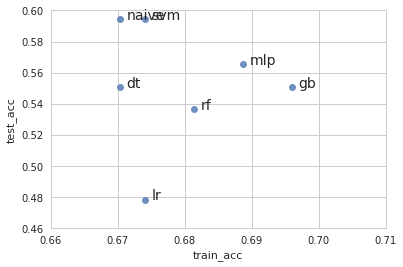

In [127]:
ax = sns.regplot(x=brasil_clf_df["train_acc"], y=brasil_clf_df["test_acc"],fit_reg=False,label="log da pnad")

ax.set(xlim=(0.66,0.71))
ax.set(ylim=(0.46,0.6))


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.001, point['y'], str(point['val']),size=14)

label_point(brasil_clf_df["train_acc"], brasil_clf_df["test_acc"], brasil_clf_df["classifier"], ax) 

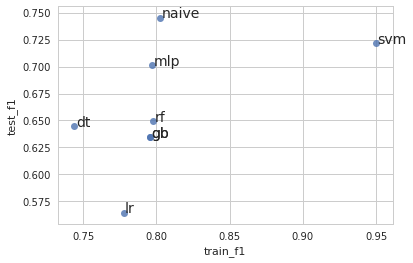

In [161]:
ax = sns.regplot(x=brasil_clf_df["train_f1"], y=brasil_clf_df["test_f1"],fit_reg=False,label="log da pnad")
label_point(brasil_clf_df["train_f1"], brasil_clf_df["test_f1"], brasil_clf_df["classifier"], ax) 

Nosso SVM parece então ser o melhor classificador na amostra de teste, mas é bem interessante como ele não consegue superar o classificador "torcedor fanático" (chuta sempre que vai ganhar, o naive), tanto em acurácia quanto em F1. Isso indica que nossos dados não são muito bons para prever o desempenho em uma partida. 

Alguns fatores podem estar contribuindo para isso, em que o mais importante parece ser a baixa quantidade de linhas. E essa é a principal desvantagem de fazermos um Digital Twin de um país apenas: nossos classificadores não tem dados o suficiente para aprender algum padrão nos dados.

# 3. Digital Twin das seleções

Como usar somente os dados de uma seleção para prever resultados é muito ruim, vamos utilizar os dados de todas.

In [20]:
ranking_fifa['AAAA-MM'] = ranking_fifa['rank_date'].str[:7]
game_result['AAAA-MM'] = game_result['date'].str[:7]
    
game_results_hometeam = pd.merge(game_result.drop(['tournament','city','country','neutral'],axis=1), 
                                 ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['home_team','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                       )

game_results_rk = pd.merge(game_results_hometeam, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['away_team','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                        suffixes=('','_away')
                       )

game_results_rk.shape

(17308, 36)

In [24]:
game_results_rk['TARGET'] = construct_target(game_results_rk,'home_score','away_score')

In [26]:
variables = ['rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 'cur_year_avg_weighted', 'last_year_avg',
'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg', 'three_year_ago_weighted']

variables = variables + [x+'_away' for x in variables]

In [27]:
X_train, X_test,y_train,y_test = train_test_split(game_results_rk[variables], game_results_rk['TARGET'],
                                                  test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13846, 24)
(3462, 24)
(13846,)
(3462,)


In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'lr',
                                      'estimator':lrclf.best_estimator_, 
                                      'train_acc' : lrclf.best_score_,
                                      'test_acc' : test_acc_lrclf}, ignore_index=True)

## Decision Trees

In [ ]:
dtc_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : list(range(2,100)) + [None],
    'class_weight' : [None,'balanced']
}

clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=dtc_candidates, n_jobs=-1, cv= 5, verbose = True)

cv = clf.fit(X_train,y_train)

In [ ]:
print('Best score for dt:', clf.best_score_) 
print('Best min_samples_leaf:',clf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',clf.best_estimator_.max_depth)
print('Best class_weight:',clf.best_estimator_.class_weight)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = clf.best_estimator_.predict(X_test)

test_acc_clf = accuracy_score(y_test,y_pred)
test_acc_clf

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'dt',
                                      'estimator':clf.best_estimator_, 
                                      'train_acc' : clf.best_score_,
                                      'test_acc' : test_acc_clf}, ignore_index=True)
all_clf_df.head(5)

## Support Vector Machine, as multi-classifier

In [ ]:
svc_candidates = {
    'C' : [i/1000.0 for i in range(1,2000,1)],
}

svcclf = GridSearchCV(estimator=SVC(), param_grid=svc_candidates, n_jobs=-1, cv= 5, verbose = True)

cv = svcclf.fit(X_train,y_train)

In [ ]:
print('Best score for svcclf:', svcclf.best_score_) 
print('Best C:',svcclf.best_estimator_.C) 
print('Best kernel:',svcclf.best_estimator_.kernel)
print('Best class_weight:',svcclf.best_estimator_.class_weight)

In [ ]:
y_pred = svcclf.best_estimator_.predict(X_test)

test_acc_svcclf = accuracy_score(y_test,y_pred)
test_acc_svcclf

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'svm',
                                      'estimator':svcclf.best_estimator_, 
                                      'train_acc' : svcclf.best_score_,
                                      'test_acc' : test_acc_svcclf}, ignore_index=True)

## Logistic Regression, One vs Rest

In [ ]:
lr_candidates = {
    'penalty' : ['l1','l2'],
    'C' : [x/10.0 for x in range(900,1110,1)],
    'class_weight' : [None,'balanced'],
    'multiclass' : ['ovr', 'multinomial']
}

lrclf = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_candidates, n_jobs=-1, cv= 5, verbose = True)

cv = lrclf.fit(X_train,y_train)

In [ ]:
print('Best score for lrclf:', lrclf.best_score_) 
print('Best C:',lrclf.best_estimator_.C) 
print('Best penalty:',lrclf.best_estimator_.penalty)
print('Best class_weight:',lrclf.best_estimator_.class_weight)
print('Best multiclass:',lrclf.best_estimator_.multiclass)

In [ ]:
y_pred = lrclf.best_estimator_.predict(X_test)

test_acc_lrclf = accuracy_score(y_test,y_pred)
test_acc_lrclf

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'lr',
                                      'estimator':lrclf.best_estimator_, 
                                      'train_acc' : lrclf.best_score_,
                                      'test_acc' : test_acc_lrclf}, ignore_index=True)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : [None],
    'class_weight' : [None,'balanced'],
    'n_estimators' : list(range(10,100,10))
}

rfclf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_candidates, n_jobs=-1, cv= 5, verbose = True)

cv = rfclf.fit(X_train,y_train)

In [ ]:
print('Best score for rfclf:', rfclf.best_score_) 
print('Best min_samples_leaf:',rfclf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',rfclf.best_estimator_.max_depth)
print('Best class_weight:',rfclf.best_estimator_.class_weight)
print('Best n_estimators:',rfclf.best_estimator_.n_estimators)

In [ ]:
y_pred = rfclf.best_estimator_.predict(X_test)

test_acc_rfclf = accuracy_score(y_test,y_pred)
test_acc_rfclf

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'rf',
                                      'estimator':rfclf.best_estimator_, 
                                      'train_acc' : rfclf.best_score_,
                                      'test_acc' : test_acc_rfclf}, ignore_index=True)

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : [None],
    'n_estimators' : list(range(10,100,10)),
    'learning_rate' : [0.001,0.01,0.1,0.5,1.0]
}

gbclf = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_candidates, n_jobs=-1, cv= 5, verbose = True)

cv = gbclf.fit(X_train,y_train)

In [ ]:
print('Best score for gbclf:', gbclf.best_score_) 
print('Best min_samples_leaf:',gbclf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',gbclf.best_estimator_.max_depth)
print('Best n_estimators:',gbclf.best_estimator_.n_estimators)

In [ ]:
y_pred = gbclf.best_estimator_.predict(X_test)

test_acc_gbclf = accuracy_score(y_test,y_pred)
test_acc_gbclf

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'gb',
                                      'estimator':gbclf.best_estimator_, 
                                      'train_acc' : gbclf.best_score_,
                                      'test_acc' : test_acc_gbclf}, ignore_index=True)

## Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_candidates = {
    'alpha' : [0.001,0.01] + [i/10.0 for i in range(1,11)],
    'learning_rate' : ['constant','invscaling', 'adaptive'],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'max_iter' : [1000]
}

mlpclf = GridSearchCV(estimator=MLPClassifier(), param_grid=mlp_candidates, n_jobs=-1, cv= 5, verbose = True)

cv = mlpclf.fit(X_train,y_train)

In [ ]:
print('Best score for mlpclf:', mlpclf.best_score_) 
print('Best alpha:',mlpclf.best_estimator_.alpha) 
print('Best learning_rate:',mlpclf.best_estimator_.learning_rate)
print('Best activation:',mlpclf.best_estimator_.activation)

In [ ]:
y_pred = mlpclf.best_estimator_.predict(X_test)

test_acc_mlpclf = accuracy_score(y_test,y_pred)
test_acc_mlpclf

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'mlp',
                                      'estimator':mlpclf.best_estimator_, 
                                      'train_acc' : mlpclf.best_score_,
                                      'test_acc' : test_acc_mlpclf}, ignore_index=True)

## Naive (chuta tudo como 'WIN')

In [ ]:
from sklearn.dummy import DummyClassifier

dumclf = DummyClassifier(strategy='most_frequent')
cv = dumclf.fit(X_train,y_train)

In [ ]:
dumclf.score(X_train,y_train)

In [ ]:
y_test_pred = dumclf.predict(X_test)
test_acc_naive = accuracy_score(y_test,y_test_pred)
test_acc_naive

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'naive', 
                                      'estimator' : dumclf, 
                                      'train_acc' : train_acc_naive,
                                      'test_acc' : test_acc_naive}, ignore_index=True)

## Summary

In [ ]:
all_clf_df['train_f1'] = all_clf_df.apply(lambda row: f1_score(row['estimator'].predict(X_train),y_train,average='weighted')
                                                ,axis=1)

all_clf_df['test_f1'] = all_clf_df.apply(lambda row: f1_score(row['estimator'].predict(X_test),y_test,average='weighted')
                                                ,axis=1)

In [ ]:
ax = sns.regplot(x=all_clf_df["train_acc"], y=all_clf_df["test_acc"],fit_reg=False,label="log da pnad")

ax.set(xlim=(0.66,0.71))
ax.set(ylim=(0.46,0.6))

label_point(all_clf_df["train_acc"], all_clf_df["test_acc"], all_clf_df["classifier"], ax) 

In [ ]:
ax = sns.regplot(x=all_clf_df["train_f1"], y=all_clf_df["test_f1"],fit_reg=False,label="log da pnad")
label_point(all_clf_df["train_f1"], all_clf_df["test_f1"], all_clf_df["classifier"], ax) 